In [21]:
import pandas as pd
import numpy as np

def read_fasta(file_path):
    names = []
    sequences = []
    current_name = ""
    current_sequence = ""

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            if line.startswith('>'):
                # If the line starts with '>', it indicates the beginning of a new sequence
                # Store the previous name and sequence
                if current_name and current_sequence:
                    names.append(current_name)
                    sequences.append(current_sequence)

                # Reset for the new sequence
                current_name = line[1:]  # Exclude the '>'
                current_sequence = ""
            else:
                # If the line doesn't start with '>', it is part of the sequence
                current_sequence += line

    # Add the last sequence to the lists
    if current_name and current_sequence:
        names.append(current_name)
        sequences.append(current_sequence)

    # Create a DataFrame
    df = pd.DataFrame({'Name': names, 'Sequence': sequences})
    return df

def process_sequence(sequence):
    # If the sequence length is less than or equal to 320, repeat it
    if len(sequence) <= 320:
        sequence = sequence * (320 // len(sequence) + 1)
    # If the sequence length is greater than 320, truncate it
    return sequence[:320]
    

def one_hot_encode_sequence(sequence, encoding_map):
    num_classes = len(encoding_map)
    one_hot_sequence = np.zeros((len(sequence), num_classes), dtype=int)

    for i, aa in enumerate(sequence):
        one_hot_sequence[i, encoding_map[aa] - 1] = 1  # Subtract 1 to convert 1-20 to 0-19 index

    return one_hot_sequence

# Example usage
amino_acid_mapping = {
    'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
    'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
    'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
    'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20
}

negative_train_file_path = '../data/drugminer/fastadata/Train/negative_train_sequence.fasta'
negative_train_fasta_df = read_fasta(negative_train_file_path)
negative_train_fasta_df['Processed_Sequence'] = negative_train_fasta_df['Sequence'].apply(process_sequence)
negative_train_fasta_df.drop(negative_train_fasta_df[negative_train_fasta_df['Processed_Sequence'].str.contains('U')].index, inplace=True)
negative_train_fasta_df.drop(negative_train_fasta_df[negative_train_fasta_df['Processed_Sequence'].str.contains('X')].index, inplace=True)
negative_train = np.array([
    one_hot_encode_sequence(seq, amino_acid_mapping)
    for seq in negative_train_fasta_df['Processed_Sequence']
])
negative_train = np.stack(negative_train, axis=0)

positive_train_file_path = '../data/drugminer/fastadata/Train/positive_train_sequence.fasta'
positive_train_fasta_df = read_fasta(positive_train_file_path)
positive_train_fasta_df['Processed_Sequence'] = positive_train_fasta_df['Sequence'].apply(process_sequence)
positive_train_fasta_df.drop(positive_train_fasta_df[positive_train_fasta_df['Processed_Sequence'].str.contains('U')].index, inplace=True)
positive_train_fasta_df.drop(positive_train_fasta_df[positive_train_fasta_df['Processed_Sequence'].str.contains('X')].index, inplace=True)
positive_train = np.array([
    one_hot_encode_sequence(seq, amino_acid_mapping)
    for seq in positive_train_fasta_df['Processed_Sequence']
])
positive_train = np.stack(positive_train, axis=0)

# Negative test set
negative_test_file_path = '../data/drugminer/fastadata/Independent_Test/negative_test_sequence.fasta'
negative_test_fasta_df = read_fasta(negative_test_file_path)
negative_test_fasta_df['Processed_Sequence'] = negative_test_fasta_df['Sequence'].apply(process_sequence)
negative_test_fasta_df.drop(negative_test_fasta_df[negative_test_fasta_df['Processed_Sequence'].str.contains('U')].index, inplace=True)
negative_test_fasta_df.drop(negative_test_fasta_df[negative_test_fasta_df['Processed_Sequence'].str.contains('X')].index, inplace=True)
negative_test = np.array([
    one_hot_encode_sequence(seq, amino_acid_mapping)
    for seq in negative_test_fasta_df['Processed_Sequence']
])
negative_test = np.stack(negative_test, axis=0)

# Positive test set
positive_test_file_path = '../data/drugminer/fastadata/Independent_Test/positive_test_sequence.fasta'
positive_test_fasta_df = read_fasta(positive_test_file_path)
positive_test_fasta_df['Processed_Sequence'] = positive_test_fasta_df['Sequence'].apply(process_sequence)
positive_test_fasta_df.drop(positive_test_fasta_df[positive_test_fasta_df['Processed_Sequence'].str.contains('U')].index, inplace=True)
positive_test_fasta_df.drop(positive_test_fasta_df[positive_test_fasta_df['Processed_Sequence'].str.contains('X')].index, inplace=True)
positive_test = np.array([
    one_hot_encode_sequence(seq, amino_acid_mapping)
    for seq in positive_test_fasta_df['Processed_Sequence']
])
positive_test = np.stack(positive_test, axis=0)

In [4]:
X_train = np.concatenate([positive_train, negative_train], axis=0)
y_train = np.concatenate([np.ones(len(positive_train)), np.zeros(len(negative_train))])

# Combine positive and negative sets for testing
X_test = np.concatenate([positive_test, negative_test], axis=0)
y_test = np.concatenate([np.ones(len(positive_test)), np.zeros(len(negative_test))])

from sklearn.utils import shuffle
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
# Shuffle training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Shuffle test data
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [3]:
import warnings
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, \
                    matthews_corrcoef, ConfusionMatrixDisplay,f1_score, \
                    accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d, functional as F, BatchNorm1d, LazyLinear
from torch.optim import Optimizer
import os
import pandas as pd
import matplotlib.pyplot as plt

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
warnings.filterwarnings("ignore", category=Warning)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda:0


In [5]:
X_train = torch.tensor(X_train).to(torch.float32)
y_train = torch.tensor(y_train).to(torch.long)

X_test = torch.tensor(X_test).to(torch.float32)
y_test = torch.tensor(y_test).to(torch.long)

In [6]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(320 * 20, 180 * 10)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(180 * 10, 60 * 5)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60 * 5, 30)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [7]:
model = Deep()

In [9]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                y_batch = y_batch.view(-1, 1).to(torch.float32)
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

2023-11-12 14:57:37.566734: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-12 14:57:37.710640: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 14:57:37.710681: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 14:57:37.711383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 14:57:37.777339: I tensorflow/core/platform/cpu_feature_g

Accuracy (deep): 0.51
Accuracy (deep): 0.51
Accuracy (deep): 0.50
Accuracy (deep): 0.51
Accuracy (deep): 0.50
Deep: 50.54% (+/- 0.07%)
train a deep model
Final model accuracy: 51.66%
[0. 0. 0. ... 0. 0. 0.] -> [0.99167764] (expected 1)
[0. 0. 0. ... 0. 0. 0.] -> [0.00422931] (expected 1)
[0. 0. 0. ... 0. 0. 0.] -> [0.99747914] (expected 1)
[0. 0. 0. ... 0. 0. 1.] -> [0.00781121] (expected 0)
[0. 0. 0. ... 0. 0. 0.] -> [0.00107531] (expected 0)


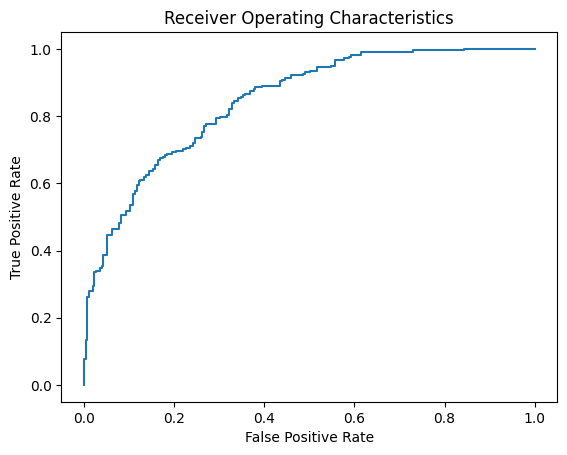

In [10]:

kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_deep = []

for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)


deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))


print("train a deep model")
model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1].to(device)).cpu()
        print(f"{X_test[i].cpu().numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

    # Plot the ROC curve
    y_pred = model(X_test.to(device)).cpu()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [ ]:
with torch.no_grad():
    y_pred = model(X_test.to(device))
    y_pred = (y_pred > 0.5).int().reshape(-1)
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())
mcc = matthews_corrcoef(y_test.cpu().numpy(), y_pred.cpu().numpy())
f1 = f1_score(y_test.cpu().numpy(), y_pred.cpu().numpy())
recall = recall_score(y_test.cpu().numpy(), y_pred.cpu().numpy())

print(f"Accuracy: {accuracy:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")